# Surface Roughness Metrics  
Compute TRI using the Riley algorithm (https://gdal.org/programs/gdaldem.html#tri) at resolutions of native (1-3m), 20m, 100m  

To Do:  
Coarsen the Snow-Off DTMs, then compute TRI:
* GM: 3, 20, 100m
* Methow: 1, 20, 100m
* Tuolumne: 1, 20, 100m  

To coarsen:  
gdalwarp -tr 20, 20 -r cubic mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma.tif mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_20m.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER  

To create TRI:  
gdaldem TRI mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_20m.tif mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_20m_tri.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER


In [29]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
from pathlib import Path
from rasterstats import zonal_stats

In [30]:
%matplotlib inline

parallel "gdalwarp --co COMPRESS=LZW -co TILED=YES --co BIGTIFF=IF_SAFER -tr 20, 20 -r cubic {} {.}_20m.tif" ::: *.tif

parallel "gdalwarp --co COMPRESS=LZW -co TILED=YES --co BIGTIFF=IF_SAFER -tr 100, 100 -r cubic {} {.}_100m.tif" ::: *_20m.tif

In [1]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_methow/notebooks


In [12]:
aso_dir = '../../data/lidar/native_res'
aso_fn_list = !ls $aso_dir/*.tif
aso_fn_list

['../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif',
 '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m.tif']

In [10]:
aso_fn_list

'../../data/lidar/native_res/*.tif'

In [16]:
type(aso_fn_list.n)

str

In [18]:
aso_fn_list.l

['../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif',
 '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m.tif']

In [19]:
(aso_fn_list.l)[0]

'../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010.tif'

In [36]:
aso_fn_list.l

['../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif',
 '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010_20.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010_20.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010_20.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010_20.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010_20.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_20191010_100.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_20.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_100.tif',
 '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m_20.tif',
 '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m_100.tif',
 '../../data/lidar/native_res/ASO_3M_PCDTM_USCATE_201910

In [ ]:
#for dem_fn in [aso_fn_list[aso_idx], os.path.splitext(aso_fn_list[aso_idx])+'_8x.tif']:
for dem_fn in aso_fn_list.l:
    for res in [20,100]:
        #gdaldem_fn = os.path.splitext(aso_fn_list[aso_idx])[0]+f'_{v}.tif'
        gdaldem_fn = os.path.splitext(dem_fn)[0]+f'_tri.tif'
        print(gdaldem_fn)
        if not os.path.exists(gdaldem_fn):
            !gdaldem TRI {dem_fn} {gdaldem_fn} -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER
        gdaldem_fn = os.path.splitext(dem_fn)[0]+f'_{res}.tif'
        print(gdaldem_fn)
        if not os.path.exists(gdaldem_fn):
            !gdalwarp -tr {res}, {res} -r cubic {dem_fn} {gdaldem_fn} -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER 
        #aso_fn_list.append(gdaldem_fn)
        gdaldem_src = rio.open(gdaldem_fn)

## Tuolumne

In [56]:
# Change the nodata value of the original tuolumne snowoff data so that edge effects aren't an issue
# https://gis.stackexchange.com/questions/369064/how-to-convert-0-values-to-nodata-values-with-rasterio
source_raster_path = "../../data/lidar/tuolumne/snow_off/ASO_snowoff_linux/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_10m.tif"
distination_raster_path = "../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_10m_ma_only.tif"
with rio.open(source_raster_path, "r+") as src:
    src.nodata = 0 # set the nodata value
    profile = src.profile
    profile.update(
            nodata=0
    )

    with rio.open(distination_raster_path, 'w',  **profile) as dst:
        band = src.read(1)
        # band = np.where(band!=1,0,band) # if value is not equal to 1 assign no data value i.e. 0
        band = np.where(band==0,0,band) # for completeness
        dst.write(band,1)


## Mask out Hetch Hetchy (and other lakes/waterbodies)  
There were large negative difference values over Hetch Hetchy, which made some summer boxplots (2019-09-09) have a median of 1m instead of near 0.  
Lakes layer from https://data.cnra.ca.gov/dataset/california-lakes

In [31]:
lakes = gpd.read_file('../../data/California_Lakes.geojson')
tuol_outline = gpd.read_file('../../data/site_outlines/UpperTuolRiverBasinOutline.geojson')

In [34]:
lakes = lakes.to_crs(tuol_masked_src.crs)
tuol_outline = tuol_outline.to_crs(tuol_masked_src.crs)

In [35]:
lakes = gpd.clip(lakes, tuol_outline)

<AxesSubplot:>

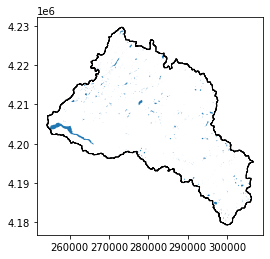

In [65]:
fig, ax = plt.subplots()

lakes.plot(ax=ax)
tuol_outline.plot(ax=ax, facecolor='none')

In [36]:
tuol_outline_nolakes = gpd.overlay(tuol_outline, lakes, how='difference')

In [37]:
tuol_outline_nolakes.to_pickle('../../data/site_outlines/tuol_outline_nolakes.pkl')

<AxesSubplot:>

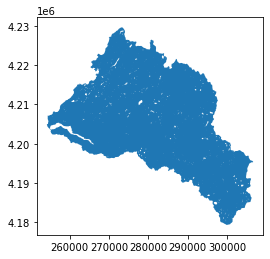

In [38]:
tuol_outline_nolakes[0:1].plot()

<AxesSubplot:>

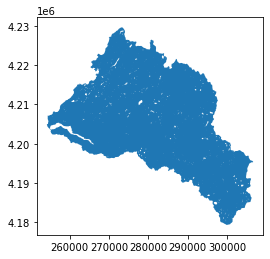

In [77]:
tuol_outline_nolakes[1:].plot()

In [78]:
tuol_outline_nolakes[1:]

,DN,geometry
1,1,GEOMETRYCOLLECTION Z (LINESTRING Z (281303.787...


In [87]:
tuol_outline_nolakes[0:1].geometry.values

<GeometryArray>
Length: 1, dtype: geometry

In [39]:
# Convert to a shapely polygon for clipping the raster.
shape = tuol_outline_nolakes.loc[0, 'geometry']

<AxesSubplot:>

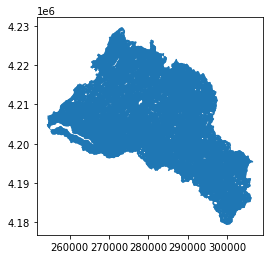

In [67]:
tuol_outline_nolakes.plot()

In [89]:
with rio.open('../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma.tif') as src:
    out_image, out_transform = rio.mask.mask(src, shape, crop=True)
    out_meta = src.meta

In [91]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open('../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma.tif', "w", **out_meta) as dest:
    dest.write(out_image)


In [33]:
tuol_masked_src = rio.open('../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma.tif')

In [100]:
tuol_maskedtri_src = rio.open('../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_tri2.tif')

In [63]:
tuol_slope_src = rio.open('../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_90m_slope.tif')

In [64]:
tuol_slope_src.crs

CRS.from_wkt('PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [125]:
tuol_maskedtri_src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 17468, 'height': 16771, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(3.0, 0.0, 254247.0,
       0.0, -3.0, 4229643.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [95]:
tuol_masked = tuol_masked_src.read(1, masked=True)

In [101]:
tuol_maskedtri = tuol_maskedtri_src.read(1, masked=True)

In [58]:
tuol_slope = tuol_slope_src.read(1, masked=True)

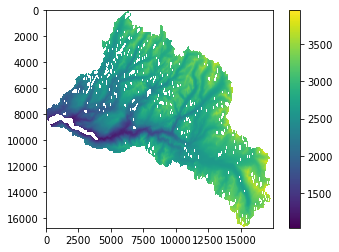

In [96]:
fig, ax = plt.subplots()

c = plt.imshow(tuol_masked)
plt.colorbar(c)


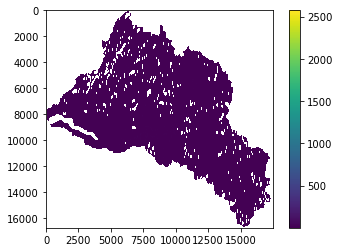

In [102]:
fig, ax = plt.subplots()

c = plt.imshow(tuol_maskedtri)
plt.colorbar(c)

In [99]:
rxr.open_rasterio('../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma.tif', masked=True).squeeze()

<xarray.DataArray (y: 16771, x: 17468)>
[292955828 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 2.542e+05 2.543e+05 ... 3.066e+05 3.066e+05
  * y            (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [112]:
tuol_maskedtri.max()

2573.1997

In [113]:
tuol_maskedtri.min()

0.008943682

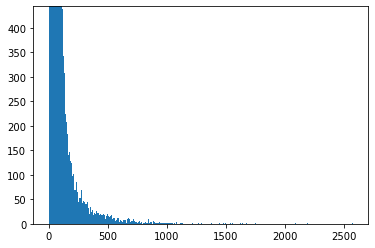

In [119]:
f,ax = plt.subplots()
plt.hist(np.ravel(tuol_maskedtri), bins=400)
plt.ylim(0,444);

### SLOPE

In [68]:
stats_tuol_slope_3m = zonal_stats(tuol_outline_nolakes, '../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_tuol_slope_3m

[{'min': 0.0,
  'max': 89.7177734375,
  'mean': 22.053019720913767,
  'std': 13.816843294064707,
  'median': 19.895065307617188,
  'percentile_25': 11.203753471374512,
  'percentile_75': 30.54454231262207},
 {'min': 0.0,
  'max': 89.7177734375,
  'mean': 22.053019720913767,
  'std': 13.816843294064707,
  'median': 19.895065307617188,
  'percentile_25': 11.203753471374512,
  'percentile_75': 30.54454231262207}]

In [69]:
stats_tuol_slope_20m = zonal_stats(tuol_outline_nolakes, '../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_20m_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_tuol_slope_20m

[{'min': 0.0012608817778527737,
  'max': 82.43804168701172,
  'mean': 20.678076192358258,
  'std': 12.773713473163074,
  'median': 18.706737518310547,
  'percentile_25': 10.42603874206543,
  'percentile_75': 29.25722885131836},
 {'min': 0.0012608817778527737,
  'max': 82.43804168701172,
  'mean': 20.678076192358258,
  'std': 12.773713473163074,
  'median': 18.706737518310547,
  'percentile_25': 10.42603874206543,
  'percentile_75': 29.25722885131836}]

In [70]:
stats_tuol_slope_90m = zonal_stats(tuol_outline_nolakes, '../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_90m_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_tuol_slope_90m

[{'min': 0.009732679463922977,
  'max': 66.95703125,
  'mean': 18.806789318957666,
  'std': 11.203804402007185,
  'median': 17.108997344970703,
  'percentile_25': 9.727766036987305,
  'percentile_75': 26.553977012634277},
 {'min': 0.009732679463922977,
  'max': 66.95703125,
  'mean': 18.806789318957666,
  'std': 11.203804402007185,
  'median': 17.108997344970703,
  'percentile_25': 9.727766036987305,
  'percentile_75': 26.553977012634277}]

### TRI

In [123]:
stats_tuol_tri = zonal_stats(tuol_outline_nolakes, '../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [124]:
stats_tuol_tri

[{'min': 0.0054591502994298935,
  'max': 2573.19970703125,
  'mean': 3.550888612496014,
  'std': 3.6770947884327354,
  'median': 2.8609323501586914,
  'percentile_25': 1.6733325719833374,
  'percentile_75': 4.511236667633057},
 {'min': 0.0054591502994298935,
  'max': 2573.19970703125,
  'mean': 3.550888612496014,
  'std': 3.6770947884327354,
  'median': 2.8609323501586914,
  'percentile_25': 1.6733325719833374,
  'percentile_75': 4.511236667633057}]

In [126]:
stats_tuol_tri20 = zonal_stats(tuol_outline_nolakes, '../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_20m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [127]:
stats_tuol_tri20

[{'min': 0.08045387268066406,
  'max': 726.405517578125,
  'mean': 21.036188223065594,
  'std': 15.664345739143323,
  'median': 17.553375244140625,
  'percentile_25': 9.91866683959961,
  'percentile_75': 28.352954864501953},
 {'min': 0.08045387268066406,
  'max': 726.405517578125,
  'mean': 21.036188223065594,
  'std': 15.664345739143323,
  'median': 17.553375244140625,
  'percentile_25': 9.91866683959961,
  'percentile_75': 28.352954864501953}]

In [128]:
stats_tuol_tri100 = zonal_stats(tuol_outline_nolakes, '../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_100m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [129]:
stats_tuol_tri100

[{'min': 0.4514288902282715,
  'max': 576.2339477539062,
  'mean': 95.27735618788941,
  'std': 58.609217529086145,
  'median': 84.08203887939453,
  'percentile_25': 50.218563079833984,
  'percentile_75': 129.6288070678711},
 {'min': 0.4514288902282715,
  'max': 576.2339477539062,
  'mean': 95.27735618788941,
  'std': 58.609217529086145,
  'median': 84.08203887939453,
  'percentile_25': 50.218563079833984,
  'percentile_75': 129.6288070678711}]

In [40]:
stats_tuol_tri90 = zonal_stats(tuol_outline_nolakes, '../../data/lidar/native_res/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_ma_90m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [41]:
stats_tuol_tri90

[{'min': 0.30865025520324707,
  'max': 530.9514770507812,
  'mean': 86.59249276156484,
  'std': 54.082781775392256,
  'median': 76.12874603271484,
  'percentile_25': 45.16400337219238,
  'percentile_75': 118.13136291503906},
 {'min': 0.30865025520324707,
  'max': 530.9514770507812,
  'mean': 86.59249276156484,
  'std': 54.082781775392256,
  'median': 76.12874603271484,
  'percentile_25': 45.16400337219238,
  'percentile_75': 118.13136291503906}]

## Methow

In [137]:
methow1_src = rio.open('../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m.tif')

In [138]:
methow1_src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 58261, 'height': 69655, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(2.9999999999999996, 0.0, 1617506.0,
       0.0, -2.9999999999999996, 1268590.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': Tr

In [10]:
methow_tri20_src = rio.open('../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m_20_tri.tif')

In [171]:
methow_tri20_rxr = rxr.open_rasterio('../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m_20_tri.tif', masked=True).squeeze()

In [159]:
methow_tri20_src.crs

CRS.from_wkt('PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [5]:
methow_outline = gpd.read_file('../../data/site_outlines/methow_outline.geojson')

<AxesSubplot:>

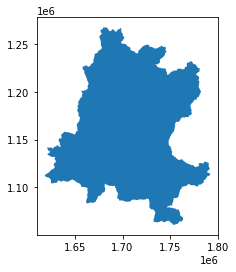

In [153]:
methow_outline[3:].plot()

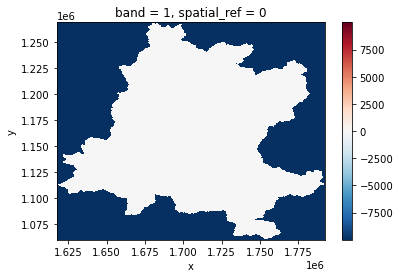

In [167]:
methow_tri20_rxr.plot()

In [142]:
methow_outline.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
methow_outline = methow_outline.to_crs(methow_tri20_src.crs)

In [158]:
methow_outline.crs

<Projected CRS: PROJCS["NAD83(HARN) / Washington South (ftUS)",GEO ...>
Name: NAD83(HARN) / Washington South (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [145]:
methow_tri20 = methow_tri20_src.read(1, masked=True)

<AxesSubplot:>

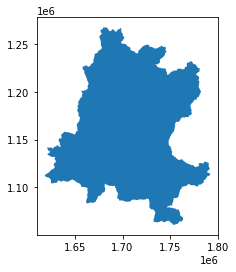

In [162]:
(methow_outline[3:]).to_crs(methow_tri20_src.crs).plot()

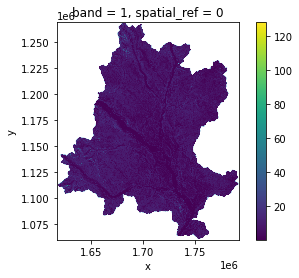

In [173]:
fig, ax = plt.subplots()

methow_outline[3:].plot(ax=ax)
methow_tri20_rxr.plot(ax=ax)


In [2]:
from rasterstats import zonal_stats

### SLOPE

In [66]:
stats_methow_slope_3m = zonal_stats(methow_outline[3:], '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_3m_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")

[{'min': 0.0,
  'max': 77.68683624267578,
  'mean': 20.016475527692588,
  'std': 10.44408691996104,
  'median': 20.36705780029297,
  'percentile_25': 12.211202383041382,
  'percentile_75': 27.74652671813965}]

In [67]:
stats_methow_slope_3m

[{'min': 0.0,
  'max': 86.4806137084961,
  'mean': 21.095824095360516,
  'std': 11.240044167597258,
  'median': 21.506418228149414,
  'percentile_25': 12.535143852233887,
  'percentile_75': 29.38256072998047}]

In [65]:
stats_methow_slope_20m = zonal_stats(methow_outline[3:], '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_20m_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_methow_slope_20m

[{'min': 0.0,
  'max': 77.68683624267578,
  'mean': 20.016475527692588,
  'std': 10.44408691996104,
  'median': 20.36705780029297,
  'percentile_25': 12.211202383041382,
  'percentile_75': 27.74652671813965}]

In [60]:
stats_methow_slope_90m = zonal_stats(methow_outline[3:], '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_90m_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [61]:
stats_methow_slope_90m

[{'min': 0.008108447305858135,
  'max': 58.05751419067383,
  'mean': 17.731954409206292,
  'std': 9.080844854549182,
  'median': 17.83053207397461,
  'percentile_25': 10.959393501281738,
  'percentile_75': 24.40279197692871}]

### TRI

In [15]:
stats_methow_tri3 = zonal_stats(methow_outline[3:], '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_3m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [16]:
stats_methow_tri3

[{'min': 0.0016194457421079278,
  'max': 449.6305236816406,
  'mean': 9.917840639876765,
  'std': 6.26423838554815,
  'median': 9.580155372619629,
  'percentile_25': 5.502495765686035,
  'percentile_75': 13.605724334716797}]

In [22]:
stats_methow_tri20 = zonal_stats(methow_outline[3:], '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_20m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [21]:
stats_methow_tri20

[{'min': 0.0009765625,
  'max': 447.4436950683594,
  'mean': 19.99471976235281,
  'std': 12.096178550937477,
  'median': 19.415756225585938,
  'percentile_25': 11.29884123802185,
  'percentile_75': 27.461647033691406}]

In [24]:
stats_methow_tri100 = zonal_stats(methow_outline[3:], '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_100m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [25]:
stats_methow_tri100

[{'min': 1.068917155265808,
  'max': 1270.302490234375,
  'mean': 286.39724321465735,
  'std': 139.98903041860012,
  'median': 283.9802551269531,
  'percentile_25': 188.2980194091797,
  'percentile_75': 379.36993408203125}]

In [26]:
stats_methow_tri90 = zonal_stats(methow_outline[3:], '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_90m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [27]:
stats_methow_tri90

[{'min': 0.3915100693702698,
  'max': 1182.1636962890625,
  'mean': 260.2925852991265,
  'std': 128.57318669404023,
  'median': 257.8448486328125,
  'percentile_25': 170.02852630615234,
  'percentile_75': 346.1239013671875}]

## Grand Mesa

In [42]:
gm_src = rio.open('../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif')

In [51]:
gm_src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 12450, 'height': 6500, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(3.0, 0.0, 218313.0,
       0.0, -3.0, 4336122.0), 'tiled': False, 'interleave': 'band'}

In [43]:
gm = gm_src.read(1, masked=True)

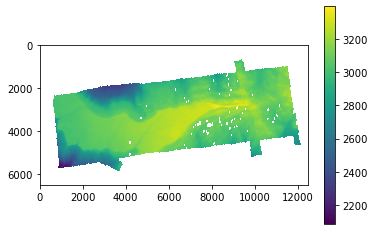

In [44]:
fig, ax = plt.subplots()

c = plt.imshow(gm)
plt.colorbar(c)

In [45]:
gm_outline = gpd.read_file('../../data/site_outlines/gm_outline.geojson')

<AxesSubplot:>

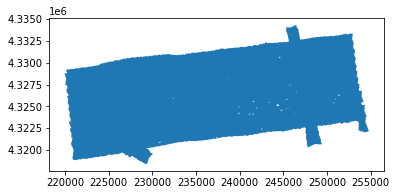

In [47]:
fig, ax = plt.subplots()

gm_outline.plot(facecolor=none, edgecolor='k')

In [48]:
gm_outline.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### SLOPE

In [71]:
stats_gm_3m_slope = zonal_stats(gm_outline, '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_gm_3m_slope

[{'min': 0.0,
  'max': 87.86670684814453,
  'mean': 10.122798630075856,
  'std': 9.635255917499181,
  'median': 6.982396602630615,
  'percentile_25': 2.8604423999786377,
  'percentile_75': 14.663732528686523}]

In [72]:
stats_gm_20m_slope = zonal_stats(gm_outline, '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_20m_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_gm_20m_slope

[{'min': 0.0,
  'max': 68.18426513671875,
  'mean': 8.810676371971216,
  'std': 8.210305135408028,
  'median': 6.27967643737793,
  'percentile_25': 2.5813549757003784,
  'percentile_75': 12.52809762954712}]

In [73]:
stats_gm_90m_slope = zonal_stats(gm_outline, '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_90m_slope.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_gm_90m_slope

[{'min': 0.005643652286380529,
  'max': 43.20126724243164,
  'mean': 7.079242278219172,
  'std': 6.338145091135501,
  'median': 5.226449966430664,
  'percentile_25': 2.208379626274109,
  'percentile_75': 9.881366968154907}]

### TRI

In [50]:
stats_gm_tri3 = zonal_stats(gm_outline, '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")

In [52]:
stats_gm_tri3

[{'min': 0.0,
  'max': 316.64984130859375,
  'mean': 1.5360632247283845,
  'std': 2.3787887820846993,
  'median': 0.999415397644043,
  'percentile_25': 0.42789896577596664,
  'percentile_75': 2.0736324787139893}]

In [53]:
stats_gm_tri20 = zonal_stats(gm_outline, '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_20m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_gm_tri20

[{'min': 0.002560568507760763,
  'max': 168.2681427001953,
  'mean': 8.521870303931292,
  'std': 8.219576571007785,
  'median': 6.182427406311035,
  'percentile_25': 2.59884774684906,
  'percentile_75': 11.742660284042358}]

In [54]:
stats_gm_tri90 = zonal_stats(gm_outline, '../../data/lidar/native_res/ASO_3M_PCDTM_USCOGM_20160926_20160926_90m_tri.tif',
            stats="mean min max median std percentile_25 percentile_75")
stats_gm_tri90

[{'min': 0.04022545740008354,
  'max': 210.1212158203125,
  'mean': 31.784013445536175,
  'std': 27.067450402061237,
  'median': 24.492626190185547,
  'percentile_25': 10.954405069351196,
  'percentile_75': 43.64951038360596}]